In [2]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/taylorduncan/dsc680/main/gold-dataset-sinha-khandait.csv"
)

print(df.columns)


Index(['Dates', 'URL', 'News', 'Price Direction Up',
       'Price Direction Constant', 'Price Direction Down', 'Asset Comparision',
       'Past Information', 'Future Information', 'Price Sentiment'],
      dtype='object')


In [4]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv("https://raw.githubusercontent.com/taylorduncan/dsc680/main/gold-dataset-sinha-khandait.csv")

DATE_COL = "Dates"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True)
df = df.sort_values(DATE_COL)

# -----------------------------
# 2) Encode target (Price Sentiment)
# -----------------------------
TARGET_COL = "Price Sentiment"

# Map sentiment strings to numeric scores
sentiment_map = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

# Clean + map
df[TARGET_COL] = (
    df[TARGET_COL]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(sentiment_map)
)

# Drop rows where sentiment couldn't be mapped
df = df.dropna(subset=[TARGET_COL])

y = df[TARGET_COL].astype(float)

# -----------------------------
# 3) Features
# -----------------------------
DROP_COLS = [DATE_COL, "URL", "News", TARGET_COL]

X = df.drop(columns=DROP_COLS, errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()
X = X.fillna(X.median(numeric_only=True))

# -----------------------------
# 4) Time-based split
# -----------------------------
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# -----------------------------
# 5) Evaluation
# -----------------------------
def evaluate(name, model):
    preds = model.predict(X_test)
    return {
        "Model": name,
        "RMSE": mean_squared_error(y_test, preds, squared=False),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }


# -----------------------------
# 6) Models
# -----------------------------
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1))
])

nn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=2000,
        early_stopping=True,
        random_state=42
    ))
])

models = [
    ("Linear Regression", lin_reg),
    ("Random Forest", rf),
    ("Support Vector Regression", svr),
    ("Neural Network", nn)
]

# -----------------------------
# 7) Train + results
# -----------------------------
results = []
for name, model in models:
    model.fit(X_train, y_train)
    results.append(evaluate(name, model))

results_df = pd.DataFrame(results).sort_values("RMSE")
print("\nModel Performance (Sentiment encoded as -1/0/1):\n")
print(results_df.to_string(index=False))

results_df.to_csv("model_results_sentiment_encoded.csv", index=False)
print("\nSaved: model_results_sentiment_encoded.csv")



Model Performance (Sentiment encoded as -1/0/1):

                    Model     RMSE      MAE       R2
            Random Forest 0.000000 0.000000 1.000000
           Neural Network 0.015070 0.001125 0.999758
        Linear Regression 0.069566 0.019681 0.994836
Support Vector Regression 0.099952 0.095957 0.989341

Saved: model_results_sentiment_encoded.csv


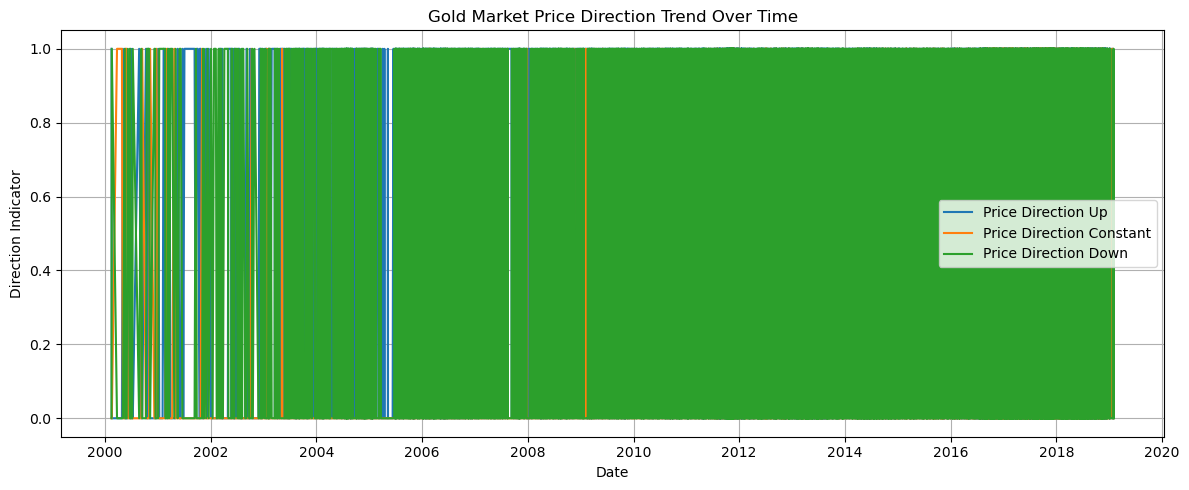

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(
    "https://raw.githubusercontent.com/taylorduncan/dsc680/main/gold-dataset-sinha-khandait.csv"
)

# Parse dates correctly (day-month-year)
df["Dates"] = pd.to_datetime(df["Dates"], dayfirst=True, errors="coerce")
df = df.sort_values("Dates")

# Plot time-series trend
plt.figure(figsize=(12, 5))
plt.plot(df["Dates"], df["Price Direction Up"], label="Price Direction Up")
plt.plot(df["Dates"], df["Price Direction Constant"], label="Price Direction Constant")
plt.plot(df["Dates"], df["Price Direction Down"], label="Price Direction Down")

plt.title("Gold Market Price Direction Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Direction Indicator")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


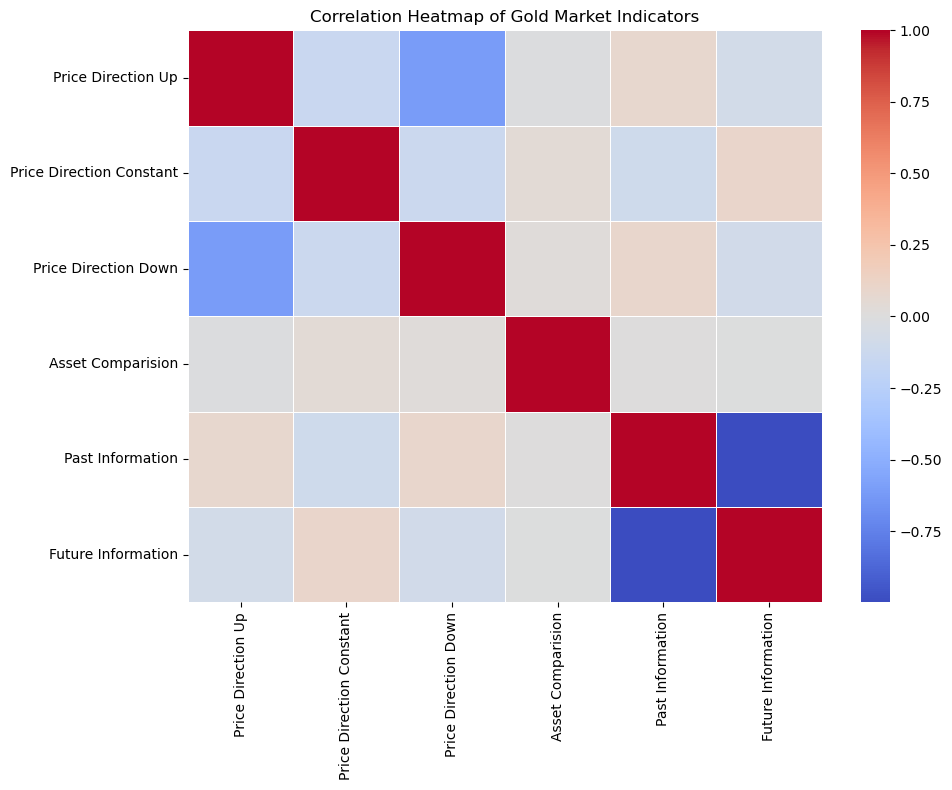

In [6]:
import seaborn as sns

# Select numeric columns only
numeric_df = df.select_dtypes(include="number")

# Correlation matrix
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Gold Market Indicators")
plt.tight_layout()
plt.show()


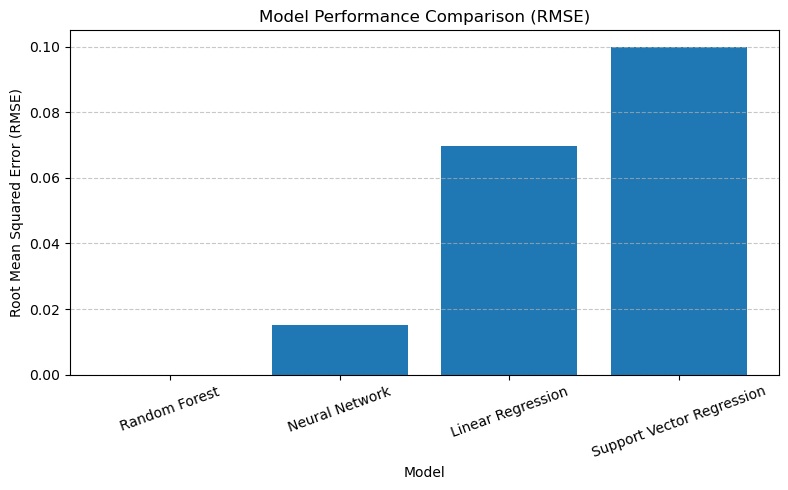

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# If results were saved earlier
results_df = pd.read_csv("model_results_sentiment_encoded.csv")

# Sort by RMSE (lower is better)
results_df = results_df.sort_values("RMSE")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["RMSE"])

plt.title("Model Performance Comparison (RMSE)")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


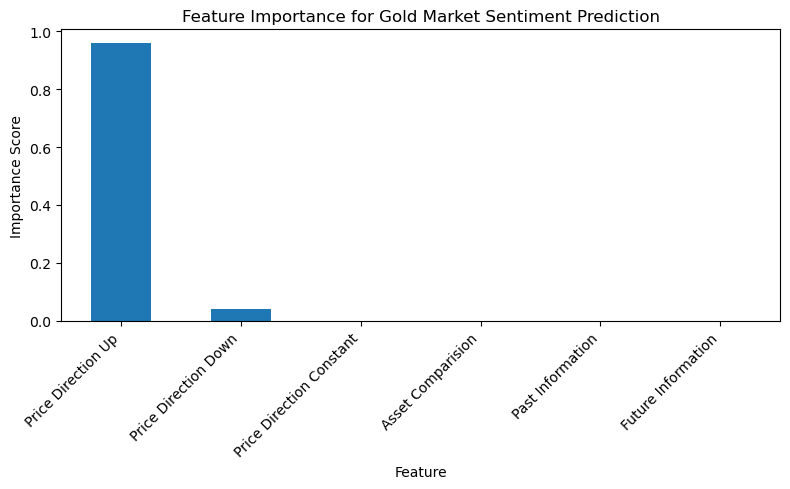

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload dataset (same preprocessing as modeling)
df = pd.read_csv(
    "https://raw.githubusercontent.com/taylorduncan/dsc680/main/gold-dataset-sinha-khandait.csv"
)

df["Dates"] = pd.to_datetime(df["Dates"], dayfirst=True, errors="coerce")
df = df.sort_values("Dates")

# Encode sentiment (same as model)
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
df["Price Sentiment"] = (
    df["Price Sentiment"]
    .astype(str)
    .str.lower()
    .map(sentiment_map)
)

df = df.dropna(subset=["Price Sentiment"])

# Features
DROP_COLS = ["Dates", "URL", "News", "Price Sentiment"]
X = df.drop(columns=DROP_COLS, errors="ignore")
X = X.select_dtypes(include="number").fillna(X.median())

y = df["Price Sentiment"]

# -----------------------------
# Train Random Forest
# -----------------------------
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X, y)

# -----------------------------
# Feature importance
# -----------------------------
importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(8, 5))
importances.plot(kind="bar")

plt.title("Feature Importance for Gold Market Sentiment Prediction")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
